# **Import libraries**

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from PIL import Image
import numpy as np
import os
import torchvision
from torchvision import transforms
from sklearn.model_selection import train_test_split
import math
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
from tqdm import tqdm
import random
from torch.linalg import vector_norm

In [2]:

# Set seed for reproducibility (produce same random seed every time the code is run)
SEED = 123

# Sets the seed for Python built-in random number generator
random.seed(SEED)

# Sets the seed for numpy library random number generator
np.random.seed(SEED)

# Sets the seed for pytorch random number generator in CPU
torch.manual_seed(SEED)

# Sets the seed for pytorch random number generator in GPU
torch.cuda.manual_seed_all(SEED)

# **Set up GPU**
You should first *Change runtime type* of the Colab notbook to enable the use of GPU.

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


# **Initialize hyperparameters**

In [4]:
batch_size = 100
num_epochs = 30
num_workers = 1

In [5]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Define dataset directory
# Change your directory in case of not using google colab
data_dir = '/content/Hey-Waldo'

# Define path to save model's state file
model_state_path = '/content/drive/MyDrive/'

# **Part 1: Data Preparation**

## 1.1 Load dataset

In [7]:
!git clone https://github.com/vc1492a/Hey-Waldo.git

Cloning into 'Hey-Waldo'...
remote: Enumerating objects: 18822, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 18822 (delta 3), reused 1 (delta 1), pack-reused 18818 (from 2)
Receiving objects: 100% (18822/18822), 112.66 MiB | 35.03 MiB/s, done.
Resolving deltas: 100% (38/38), done.
Updating files: 100% (20840/20840), done.


## 1.2 Load and preprocess data
Here the images in folder 64 will be resized to 128*128 and then all images and their labels will be converted to a numpy array.

In [8]:
# Create a function to load images from different folders, resize them if it is required and create labels
def preprocess_images(data_dir):
    all_images = []
    all_labels = []

    # Only use folder 128 and 64
    for folder in ['128', '64']:
        for subfolder in ['waldo', 'notwaldo']:
            folder_path = os.path.join(data_dir, folder, subfolder)
            # Assign label 1 to waldo and 0 to notwaldo
            label = 1 if subfolder == 'waldo' else 0
            # Set resize to true only if it is in folder 64
            resize = True if folder == '64' else False

            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)
                img = Image.open(img_path)

                if resize:
                  img = img.resize((128, 128))
                img = np.array(img)
                all_images.append(img)
                all_labels.append(label)

    return all_images, np.array(all_labels)

## 1.3 Split the dataset to train/validation/test sets

In [ ]:
# Load images and labels and preprocess them
all_images, all_labels = preprocess_images(data_dir)

# Split data: 90% for training and 10% for testing & 10% of training for validation
# random_state ensures reproducability, shuffle ensures randomization
# stratify ensures being representative of the entire dataset (having the same proportion of different classes in splitting)
train_images, test_images, train_labels, test_labels = train_test_split(all_images, all_labels, test_size=0.1, random_state=42, shuffle=True, stratify=all_labels)
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.1, random_state=42, shuffle=True, stratify=train_labels)

print(f"Training size: {len(train_images)}")
print(f"Training size Waldo: {np.sum(train_labels == 1)}")
print(f"Training size notWaldo: {np.sum(train_labels == 0)}")
print(f"Validation size: {len(val_images)}")
print(f"Test size: {len(test_images)}")

Training size: 5443
Training size Waldo: 53
Training size notWaldo: 5390
Validation size: 605
Test size: 672


The result shows the training set is quite unbalanced. In addition number of training samples without waldo is very high. Therefore, a new training images will be made. I tried two different solutions:


1.   I randomely sample an amount of train images without waldo (downsampling notWaldo) and also use data augmentation methods to create more samples with waldo (upsampling waldo).
2.   I only upsample waldo images without downsampling notWaldo.

 In the end, new created samples and the original samples are combined to create a new training set.

 Based on our observation the second method gives better training results.

In [ ]:
# diff: upsampling waldo


# Define number of images for waldo
num_waldo = 5100 # in total will be +53 (already existant waldo samples)
num_duplicate_waldo = math.floor(num_waldo / np.sum(train_labels == 1))

# Separate images with and without Waldo in the training set
waldo_images = [img for img, label in zip(train_images, train_labels) if label == 1]
not_waldo_images = [img for img, label in zip(train_images, train_labels) if label == 0]

# Convert numpy arrays to PIL Images for applying transformation
waldo_images_pil = [Image.fromarray(img) for img in waldo_images]

# Duplicate Waldo images and apply augmentation
aug_waldo_images = []
portion = num_duplicate_waldo // 5 # 5 is number of augmentation method

for img in waldo_images_pil:
    for i in range(num_duplicate_waldo):
        if i < portion * 1:
            transform = transforms.RandomHorizontalFlip(p=1.0)
        elif i < portion * 2:
            transform = transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=1.0)
        elif i < portion * 3:
            transform = transforms.RandomGrayscale(p=1.0)
        elif i < portion * 4:
            transform = transforms.RandomRotation(15)
        else:
            aug_transform = transforms.RandomVerticalFlip(p=1.0)

        aug_img = transform(img)
        aug_waldo_images.append(aug_img)


# Combining the sampled non-Waldo images with all Waldo images
final_train_images = waldo_images + not_waldo_images + aug_waldo_images
final_train_labels = [1] * len(waldo_images) + [0] * len(not_waldo_images) + [1] * len(aug_waldo_images)

# Combine and shuffle the final training set
combined_set = list(zip(final_train_images, final_train_labels))
random.shuffle(combined_set)
final_train_images, final_train_labels = zip(*combined_set)


# Convert PIL Image to a numPy array (because of warnings)
train_images_np = [np.array(img) for img in final_train_images]

# Convert the list of numPy arrays to a single NumPy array (because of warnings)
train_images = np.array(train_images_np)
train_labels = np.array(final_train_labels)

# Print final dataset sizes
print(f"Training size: {len(train_images)}")
print(f"Training size Waldo: {np.sum(train_labels == 1)}")
print(f"Training size notWaldo: {np.sum(train_labels == 0)}")
print(f"Validation size: {len(val_images)}")
print(f"Test size: {len(test_images)}")

Training size: 10531
Training size Waldo: 5141
Training size notWaldo: 5390
Validation size: 605
Test size: 672


# **Part 2: Train the model using a triplet loss**

## 2.1 Triplet Dataset Preparation



### 2.1.1 Create TripletDataset class

In [ ]:
# Create custom dataset class
# https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
# https://www.kaggle.com/code/hirotaka0122/triplet-loss-with-pytorch
# https://www.kaggle.com/code/sapthrishi007/shopee-pytorch-siamese-triplet-loss-xlmroberta/notebook?scriptVersionId=59308069

class TripletDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.to_pil = transforms.ToPILImage()

        self.triplets = self.create_triplets()

    # Create a function to create triplets (anchor, positive, negative)
    # anchore is the selected patch
    def create_triplets(self):
        triplets = []
        for idx, (img, label) in enumerate(zip(self.images, self.labels)):  # Access images and labels from constructor
            # Create positive indices for the images with the same label but not the same index
            positive_idxs = [i for i, l in enumerate(self.labels) if l == label and i != idx]
            # Create negative indices for the images with the oposite label
            negative_idxs = [i for i, l in enumerate(self.labels) if l != label]
            positive_idx = np.random.choice(positive_idxs)
            negative_idx = np.random.choice(negative_idxs)
            triplets.append((img, self.images[positive_idx], self.images[negative_idx]))
        return triplets

    def __len__(self):
        return len(self.triplets)

    def __getitem__(self, idx):
        anchor, positive, negative = self.triplets[idx]
        if self.transform:
           anchor = self.transform(self.to_pil(anchor))
           positive = self.transform(self.to_pil(positive))
           negative = self.transform(self.to_pil(negative))
           label = self.labels[idx]
           return anchor, positive, negative, label

### 2.1.2 Calculate Mean and STD

In [ ]:
# # Create a function to calculate mean and std to use in transform.Normalize
# https://discuss.pytorch.org/t/about-normalization-using-pre-trained-vgg16-networks/23560/6?u=kuzand
def calculate_mean_std(loader):
    mean, std, num_batches = 0, 0, 0

    for img, _, _, _ in loader:
        batch_size = img.size(0)
        # Reshape the image from [B, C, W, H] to [B, C, W * H] Batch, Channel, Width, Height
        # keep the first and second element at their position but flatten the rest
        # W*H is the total number of pixels in each channel of an image
        img = img.view(img.size(0), img.size(1), -1)
        # Get the mean of each image and sum them over batch
        mean += img.mean(2).sum(0)
        # Get the std of each image and sum them over batch
        std += img.std(2).sum(0)
        # Add the number of images in one batch (batch_size) to number of batches
        num_batches += batch_size

    mean /= num_batches
    std /= num_batches
    return mean, std

In [ ]:
# Create a temporary dataset to calculate mean and std of training images
temp_dataset = TripletDataset(train_images, train_labels, transform=transforms.ToTensor())
temp_loader = DataLoader(temp_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Calculate mean and std
# calculation of mean and std is only based on training data but it is applied on all datasets
mean, std = calculate_mean_std(temp_loader)

print(f"Mean of training set: {mean}")
print(f"STD of training set: {std}")

Mean of training set: tensor([0.6226, 0.5701, 0.4929])
STD of training set: tensor([0.2515, 0.2570, 0.2497])


### 2.1.3 Create Datasets and DataLoader

In [ ]:
# Transformations for data augmentation
transform_train = transforms.Compose([transforms.RandomRotation(10),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean, std)
                                      ])

transform_test_val = transforms.Compose([transforms.ToTensor(),
                                         transforms.Normalize(mean, std)
                                        ])

# Create datasets
train_set = TripletDataset(train_images, train_labels, transform=transform_train)
val_set = TripletDataset(val_images, val_labels, transform=transform_test_val)
test_set = TripletDataset(test_images, test_labels, transform=transform_test_val)

# Create DataLoaders
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)

### 2.1.4 Visualize DataLoader

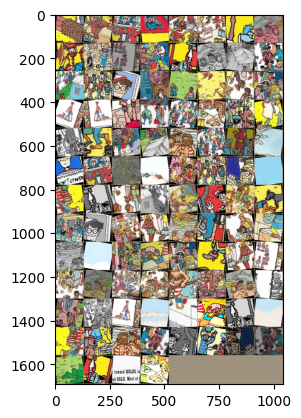

In [ ]:
# Convert from tensor to numpy
mean = mean.numpy()
std = std.numpy()

# Create a function to visualize some of the images
# WPO8 TL
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data and visualize it
for batch in iter(train_loader):
    # Unpack the triplets
    anchors, positives, negatives, _ = batch
    imshow(torchvision.utils.make_grid(anchors))
    break  # only display the first batch

In [ ]:
# Get a batch of training data
for batch in iter(train_loader):
    # Unpack the triplets
    anchors, positives, negatives, label = batch
    print(f"anchore image shape: {anchors.shape}")     # (B, C, H, W)
    print(f"positive image shape: {positives.shape}")  # (B, C, H, W)
    print(f"negative image shape: {negatives.shape}")  # (B, C, H, W)
    print(f"label shape: {label.shape}") # (B)
    break  # only display the first batch

# Get the labels for the batch
print(f"labels for the first 10 loaded images: {label[:10]}")

anchore image shape: torch.Size([100, 3, 128, 128])
positive image shape: torch.Size([100, 3, 128, 128])
negative image shape: torch.Size([100, 3, 128, 128])
label shape: torch.Size([100])
labels for the first 10 loaded images: tensor([0, 1, 0, 0, 1, 0, 0, 1, 0, 0])


In [ ]:
# Visualize dataloader with the distribution of different classes
# https://towardsdatascience.com/demystifying-pytorchs-weightedrandomsampler-by-example-a68aceccb452

def visualize_dataloader(dataLoader, label=None, with_outputs=True):
    total_num_images = len(dataLoader.dataset)
    class_0_batch_counts = []
    class_1_batch_counts = []

    for i, batch in enumerate(dataLoader):
        classes = batch[3]  # labels are in the index=3 (anchor, positive, negative, label)

        class_ids, class_counts = classes.unique(return_counts=True)
        class_ids = set(class_ids.tolist())
        class_counts = class_counts.tolist()

        if len(class_ids) == 2:
            class_0_batch_counts.append(class_counts[0])
            class_1_batch_counts.append(class_counts[1])
        elif len(class_ids) == 1 and 0 in class_ids:
            class_0_batch_counts.append(class_counts[0])
            class_1_batch_counts.append(0)
        elif len(class_ids) == 1 and 1 in class_ids:
            class_0_batch_counts.append(0)
            class_1_batch_counts.append(class_counts[0])

    if with_outputs:
        fig, ax = plt.subplots(1, figsize=(20, 6))

        ind = np.arange(len(class_0_batch_counts))
        width = 0.35

        ax.bar(
            ind,
            class_0_batch_counts,
            width,
            label=(label[0] if label is not None else "0"),
        )
        ax.bar(
            ind + width,
            class_1_batch_counts,
            width,
            label=(label[1] if label is not None else "1"),
        )
        ax.set_xticks(ind, ind + 1)
        ax.set_xlabel("Batch index", fontsize=12)
        ax.set_ylabel("No. of images in batch", fontsize=12)
        #ax.set_aspect("equal")
        fig.tight_layout()

        plt.legend()
        plt.show()

        print(
            f'Avg Proportion of {(label[0] if label is not None else "Class 0")} per batch: {round((np.array(class_0_batch_counts) / 10).mean(), 3)}'
        )
        print(
            f'Avg Proportion of {(label[1] if label is not None else "Class 1")} per batch: {round((np.array(class_1_batch_counts) / 10).mean(), 3)}'
        )

    return class_0_batch_counts, class_1_batch_counts #, idxs_seen

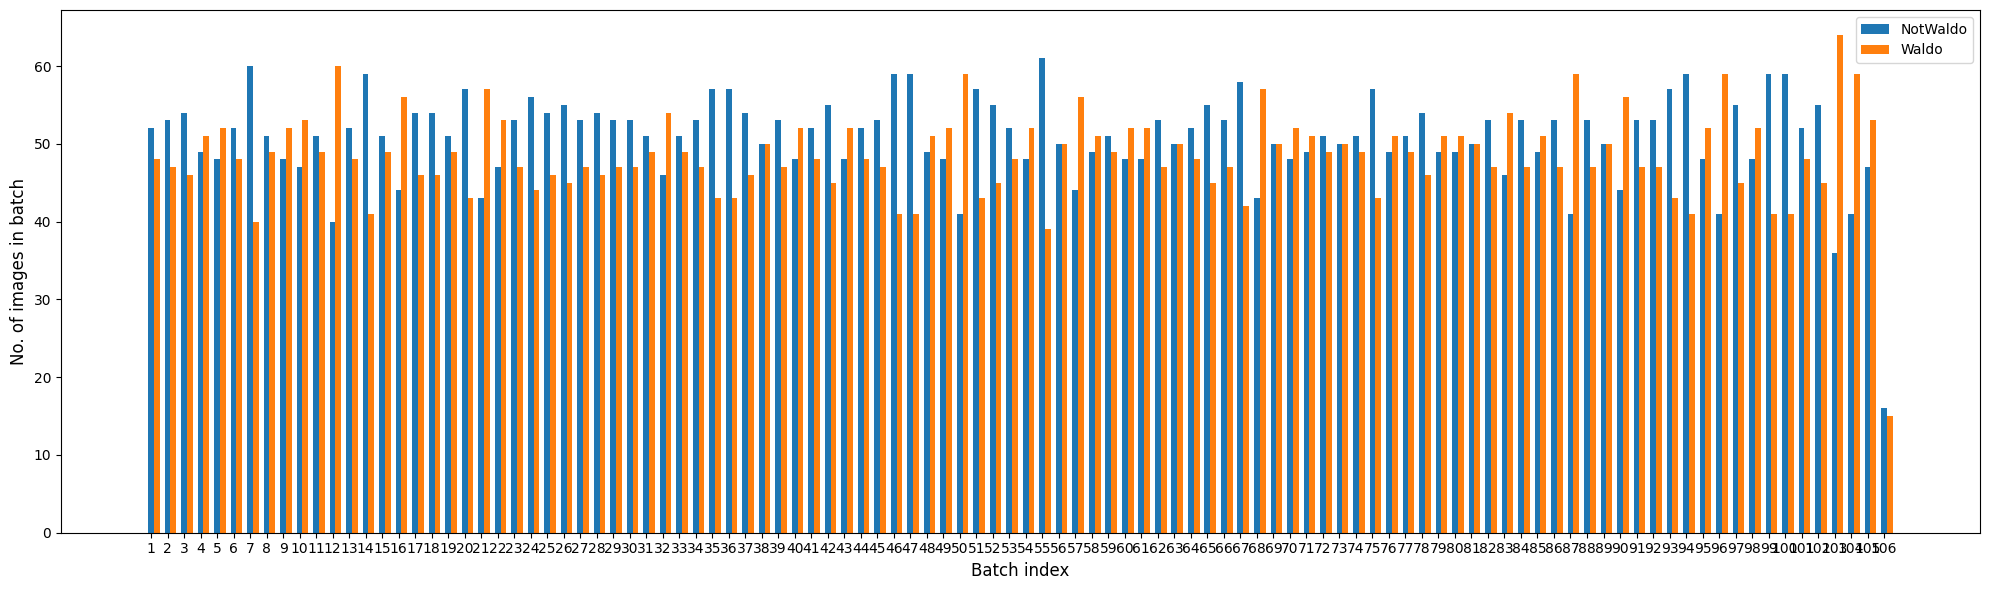

Avg Proportion of NotWaldo per batch: 5.085
Avg Proportion of Waldo per batch: 4.85


In [ ]:
# Visualize dataloader distribution per batch
class_0_batch_counts, class_1_batch_counts = visualize_dataloader(train_loader, {0: "NotWaldo", 1: "Waldo"})

### 2.1.5 Balance the dataset

The goal of this part is to make the dataset balanced by using *WeightedRandomSampler* but since we upsampeled waldo images in a way to have balanced dataset, there is no need to apply this method anymore.

In [ ]:
# Define the patchification process
class Patchify(nn.Module):

    def __init__(self, img_size, patch_size, embed_dim):
        super().__init__()
        self.num_patches = (img_size // patch_size) * (img_size // patch_size)  # height * width
        self.img_size = img_size
        self.patch_size = patch_size
        self.embed_dim = embed_dim

        self.proj = nn.Conv2d(in_channels = 3,  # RGB
                              out_channels = embed_dim,
                              kernel_size = patch_size,
                              stride = patch_size)  # no overlap between patches

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x)   # (batch_size, dim, img_size // patch_size, img_size // patch_size)
        # the input to the transformer should be of shape (batch_size, num_patches, embedding dim)
        # (batch_size, dim, img_size // patch_size, img_size // patch_size) --> flattten --> (batch_size, dim, num_patches) --> tranpose --> (batch_size, num_patches, dim)
        # faltten(2) means return the dimension 0 and 1 the same but from dimension 2 multiply all other dimensions: img_size // patch_size * img_size // patch_size = num_patches
        x = x.flatten(2).transpose(1,2)
        return x

In [ ]:
# Define the Feed Forward Layer of the Transformer Encoder
class FeedForward(nn.Module):
    def __init__(self, dim, dropout ):
        super().__init__()

        self.net = nn.Sequential(
            # Normalize input across the features for each sample in a mini-batch.
            # useful for stabilizing the learning process.
            # dim: dimension of patch embeddings.
            nn.LayerNorm(dim),
            # Multiplying input with a weight matrix and adding a bias in a fully connected layer.
            # Transforms the input with dim to dim*4 (allows network to learn more features)
            nn.Linear(dim, dim * 4),
            # Introduce non linearity to the model. outputs the input directly if it's positive, otherwise 0.
            nn.ReLU(),
            # Randomely ignores selected neurons during training based on the value dropout (the probability of a neuron being dropped out).
            # Regularization technique by preventing the model from becoming too reliant on any single neuron.
            nn.Dropout(dropout),
            # dim * 4 --> dim features.
            nn.Linear(dim * 4, dim),
            # Add more regularization.
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
# Define the Multi-Head Attention of the Transformer Encoder
class MultiHeadAttention(nn.Module):

    def __init__(self, dim, heads, dropout):
        super().__init__()
        self.dim = dim
        self.heads = heads

        self.query = nn.Linear(dim, dim)
        self.keys = nn.Linear(dim, dim)
        self.values = nn.Linear(dim, dim)

        self.norm = nn.LayerNorm(dim)
        self.out_proj = nn.Linear(dim, dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # N: total number of patches
        B, N, C = x.shape

        x = self.norm(x)         # (B, N, C)

        query = self.query(x)    # (B, N, C)
        key = self.keys(x)       # (B, N, C)
        value = self.values(x)   # (B, N, C)

        dim_head = C // self.heads

        # Split (B,N,C) into (B, N, num_heads, dim_head) --> permute --> (B, num_heads, N, dim_head) because each of the heads, should have (N, dim_head)
        # permute(0,2,1,3) change the position of dim 1 and 2
        query = query.reshape(B, N, self.heads, dim_head).permute(0,2,1,3)
        key = key.reshape(B, N, self.heads, dim_head).permute(0,2,1,3)
        value = value.reshape(B, N, self.heads, dim_head).permute(0,2,1,3)

        # Matrix multiplication of (B, num_heads, N, dim_head) with (B, num_heads, dim_head, N) --> (B, num_heads, N, N)
        # key.transpose(-1, -2): -1 is the last dimension (dim_head). -2 is the second to last dimension (N).
        # so (B, num_heads, N, dim_head) --> transpose --> (B, num_heads, dim_head, N)
        attention_scores = torch.matmul(query, key.transpose(-1, -2))

        scale = dim_head ** -0.5   # (1 / sqrt(dim_head))
        attention_scores = attention_scores * scale
        # Softmax: convert a set of raw scores (logits) into probabilities.
        # The output is a tensor of the same shape as the input, but with values in range (0, 1) that sum to 1 along the specified dimension.
        # softmax is applied to the scores to convert them into attention weights.
        # attention weights: probabilities that shows how much attention (focus) the model should put on each element when computing the weighted sum of values.
        # softmax is applied across the last dimension (dim = -1) in standard attention score with shape (B, num_heads, N, N)
        attention_scores = F.softmax(attention_scores, dim = -1) # (B, num_heads, N, N)
        attention_scores = self.dropout(attention_scores)

        # extract the values
        # (B, num_heads, N, N) matmul (B, num_heads, N, dim_head) --> (B, num_heads, N, dim_head)
        out = torch.matmul(attention_scores, value)

        # (B, num_heads, N, dim_head) --> permute --> (B, N, num_heads, dim_head) --> flatten --> (B, N, C)
        out = out.permute(0,2,1,3).flatten(2)
        out = self.out_proj(out)
        return out

In [ ]:
# Define the Transformer Encoder
class Transformer(nn.Module):
    def __init__(self, dim, num_layers, heads, dropout):

        super().__init__()

        self.norm = nn.LayerNorm(dim)
        self.layers = nn.ModuleList([])

        for _ in range(num_layers):
            self.layers.append(nn.ModuleList([
                                              MultiHeadAttention(dim, heads = heads, dropout = dropout),
                                              FeedForward(dim, dropout = dropout)]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x

        return self.norm(x)

In [ ]:
# Define ViT model by combining all the modules we defined above, into our final ViT model.
class ViT(nn.Module):
    def __init__(self, image_size, patch_size, num_classes, dim, num_layers, heads, dropout):
        '''
        dim: Dimension of patch embeddings.
        num_layers: Number of transformer layers.
        heads: Number of attention heads in the multi-head attention mechanism.
        '''
        super().__init__()

        self.patchify = Patchify(image_size, patch_size, dim)
        # positional encoding provides information about the position of the patches in the input sequence.
        # helps the model to consider the position of each patch when processing the image.
        # nn.Parameter means it's a learnable parameter and is updated during training.
        # (1, self.patchify.num_patches, dim) is the shape of position for each patch.
        self.pos_encoding = nn.Parameter(torch.randn(1, self.patchify.num_patches, dim))
        self.transformer = Transformer(dim, num_layers, heads, dropout = dropout)

    def forward(self, x):
        x = self.patchify(x)         # (batch_size, N, dim)
        x = x + self.pos_encoding    # (batch_size, N, dim)
        x = self.transformer(x)      # (batch_size, N, dim)
        x = x.mean(1)                # (batch_size, dim)
        return x

## 2.3 Instantiation of ViT model



In [ ]:
# diff: only upsampling waldo without downsampling notwaldo


# Create an instance of ViT model
image_size = 128
patch_size = 8
unique_classes = np.unique(train_loader.dataset.labels)
num_classes = len(unique_classes)
# overfitting --> change dim = 512 to 256
#dim = 512
# got worse so stick to dim = 512
#dim = 256
# this is the best try of dim --> increase weight_decay=0.01 to 0.02
dim = 512

# overfitting --> change num_layers = 3 to 2
#num_layers = 3
# got worse so stick to num_layers=3
#num_layers = 2
# this is the best try of num_layers --> decrease dim=512 to 256
num_layers = 3

heads = 8
# overfitting --> increase dropout = 0.1 to 0.2
#dropout = 0.1
# better but still overfitting --> increase dropout = 0.2 to 0.3 (if doesn't work stick to this)
#dropout = 0.2
# got worse --> stick to dropout=0.2
#dropout = 0.3
# this is the best try of dropout --> decrease num_layers=3 to 2
dropout = 0.125 # previousely 0.2

model_triplet = ViT(image_size = image_size,
            patch_size = patch_size,
            num_classes = num_classes,
            dim = dim,
            num_layers = num_layers,
            heads = heads,
            dropout = dropout).to(device)

# Define optimizer
## Not learning: loss does not decrease --> decrease lr=0.01 to lr=1e-3
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
## Not learning: loss does not decrease --> change optimizer to AdamW
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
# AdamW is most widely used optimizer for Transformers according to https://arxiv.org/pdf/2302.01107.pdf
# Overfitting! train loss decreases but val loss is not that much good, neg dist ar good, pos dist somehow... --> change scheduler from CosineAnnealingLR to ReduceLROnPlateau
# better but still overfitting --> decrease lr from 5e-4 to lr=1e-4 & use ReduceLROnPlateau
#optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.01)
#################################### much more better (congrats!) but still not generalizes well --> decrease lr from 1e-4 to lr=5e-5 (if didn't work keep this)
#optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
# got worse, so stick to the lr=1e-4 and focus on tuning other hyperparameters --> increase dropout from 0.1 to dropout=0.2
#optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)
# this is the best try of adjusting lr --> increase dropout=0.1 to 0.2
# adjust weight_decay=0.01 to 0.02
#optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
# got worse so stick to weight_decay=0.01
#optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.02)
# this is the best try of weight_decay --> ?
optimizer = torch.optim.AdamW(model_triplet.parameters(), lr=1e-4, weight_decay=0.025)

# Define learning rate scheduler with CosineAnnealingLR
# lr starts at the initial lr for the optimizer and gradually decreases by following a cosine curve.
# Helps to escape local minima and leads to better overal performance.
# overfitting --> use ReduceLROnPlateau
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3) #patience=4

# Define loss function
criterion = nn.TripletMarginLoss()

In [ ]:
print(model_triplet)

ViT(
  (patchify): Patchify(
    (proj): Conv2d(3, 512, kernel_size=(8, 8), stride=(8, 8))
  )
  (transformer): Transformer(
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (layers): ModuleList(
      (0-2): 3 x ModuleList(
        (0): MultiHeadAttention(
          (query): Linear(in_features=512, out_features=512, bias=True)
          (keys): Linear(in_features=512, out_features=512, bias=True)
          (values): Linear(in_features=512, out_features=512, bias=True)
          (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.125, inplace=False)
        )
        (1): FeedForward(
          (net): Sequential(
            (0): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (1): Linear(in_features=512, out_features=2048, bias=True)
            (2): ReLU()
            (3): Dropout(p=0.125, inplace=False)
            (4): Linear(i

## 2.4 Train and Test Function

In this step I tried to train the model with and without hard negative mining. Although, the model will benefit from hard negative mining, it takes too much time to train each epoch (about 30 minutes each),therefore, I proceed without hard negative mining.

In [ ]:
#diff: without considering hard negatives


# Define training loop funtion for one iteration
print_every = 50
def train(epoch):
    model_triplet.train()

    train_loss = 0
    train_positive_dist = 0
    train_negative_dist = 0
    total = 0

    for batch_idx, batch in enumerate(train_loader):
        anchor, positive, negative, labels = batch

        anchor = anchor.to(device)
        positive = positive.to(device)
        negative = negative.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        anchor_out = model_triplet(anchor)
        positive_out = model_triplet(positive)
        negative_out = model_triplet(negative)

        loss = criterion(anchor_out, positive_out, negative_out)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Calculate L2 norm
        # https://stackoverflow.com/questions/68489765/what-is-the-correct-way-to-calculate-the-norm-1-norm-and-2-norm-of-vectors-in
        # https://pytorch.org/docs/stable/generated/torch.linalg.vector_norm.html#torch.linalg.vector_norm
        positive_dist = torch.linalg.vector_norm(anchor_out - positive_out, ord=2, dim=1)
        negative_dist = torch.linalg.vector_norm(anchor_out - negative_out, ord=2, dim=1)

        train_positive_dist += positive_dist.sum().item()
        train_negative_dist += negative_dist.sum().item()

        total += labels.size(0)

        epoch_loss = train_loss/(batch_idx+1)
        epoch_positive_dist = train_positive_dist / total
        epoch_negative_dist = train_negative_dist / total

        if batch_idx % print_every == 0:
            print('Epoch {}/{}, Iter {}/{}, Train Loss: {:.3f}, Train Positive Distance: {:.3f}, , Train Negative Distance: {:.3f}'.format(epoch, num_epochs, batch_idx, len(train_loader),
                                                                                                                                          epoch_loss, epoch_positive_dist, epoch_negative_dist))

    return epoch_loss, epoch_positive_dist, epoch_negative_dist

In [ ]:
# Define test loop funtion for one iteration for validation dataloader
def test(testloader):
    model_triplet.eval()

    test_loss = 0
    test_positive_dist = 0
    test_negative_dist = 0
    total = 0

    with torch.no_grad():
        for batch_idx, batch in enumerate(testloader):
            anchor, positive, negative, labels = batch

            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)
            labels = labels.to(device)

            anchor_out = model_triplet(anchor)
            positive_out = model_triplet(positive)
            negative_out = model_triplet(negative)

            loss = criterion(anchor_out, positive_out, negative_out)

            test_loss += loss.item()

            # Calculate L2 norm
            # https://stackoverflow.com/questions/68489765/what-is-the-correct-way-to-calculate-the-norm-1-norm-and-2-norm-of-vectors-in
            # https://pytorch.org/docs/stable/generated/torch.linalg.vector_norm.html#torch.linalg.vector_norm
            positive_dist = torch.linalg.vector_norm(anchor_out - positive_out, ord=2, dim=1)
            negative_dist = torch.linalg.vector_norm(anchor_out - negative_out, ord=2, dim=1)

            test_positive_dist += positive_dist.sum().item()
            test_negative_dist += negative_dist.sum().item()

            total += labels.size(0)

    loss = test_loss/(batch_idx+1)
    positive_dist = test_positive_dist / total
    negative_dist = test_negative_dist / total
    print('Test Loss: {:.3f}, Test Positive Distance: {:.3f}, , Test Negative Distance: {:.3f}'.format(loss, positive_dist, negative_dist))
    return loss, positive_dist, negative_dist

## 2.5 Evaluation of Model on validation set

In [ ]:
# Run model

best_epoch = -1
best_loss = float('inf')
best_positive_dist = float('inf')
best_negative_dist = float('-inf')
best_dist = float('-inf')

train_losses = []
train_positive_dists = []
train_negative_dists = []

test_losses = []
test_positive_dists = []
test_negative_dists = []
test_dists = []

for epoch in range(num_epochs):
    train_epoch_loss, train_epoch_positive_dist, train_epoch_negative_dist = train(epoch)
    train_losses.append(train_epoch_loss)
    train_positive_dists.append(train_epoch_positive_dist)
    train_negative_dists.append(train_epoch_negative_dist)

    torch.cuda.empty_cache()

    test_loss, test_positive_dist, test_negative_dist = test(val_loader)
    test_losses.append(test_loss)
    test_positive_dists.append(test_positive_dist)
    test_negative_dists.append(test_negative_dist)
    # Calculate the distance between positive and negative pairs
    test_dist = test_negative_dist - test_positive_dist
    test_dists.append(test_dist)


    scheduler.step(test_loss)

    torch.cuda.empty_cache()

    # Create a dictionary to store model's parameter (state_dict), loss, positive_dist, negative_dist and the epoch number
    state = {'model': model_triplet.state_dict(),
             'loss': test_loss,
             'positive_dist': test_positive_dist,
             'negative_dist': test_negative_dist,
             'epoch': epoch}

    # If the test_dist is bigger than the so far best_dist, state will be saved in a file named model.pth
    if test_dist > best_dist:
       # If you want to save it on your google drive
       save_path = os.path.join(model_state_path, 'model_triplet.pth')
       torch.save(state, save_path)
       # If you want to save it in the current working directory (usually "/content")
       torch.save(state, 'model_triplet.pth')
       best_epoch = epoch
       best_loss = test_loss
       best_positive_dist = test_positive_dist
       best_negative_dist = test_negative_dist
print("\n" + "===================================================================" + "\n")
print(f"Best model is at epoch {best_epoch}")
print(f"Loss: {best_loss}")
print(f"Positive distance: {best_positive_dist}")
print(f"Negative distance: {best_negative_dist}")

Epoch 0/30, Iter 0/106, Train Loss: 1.824, Train Positive Distance: 6.468, , Train Negative Distance: 7.020
Epoch 0/30, Iter 50/106, Train Loss: 1.099, Train Positive Distance: 1.713, , Train Negative Distance: 1.735
Epoch 0/30, Iter 100/106, Train Loss: 1.045, Train Positive Distance: 1.351, , Train Negative Distance: 1.370
Test Loss: 1.126, Test Positive Distance: 1.049, , Test Negative Distance: 0.983
Epoch 1/30, Iter 0/106, Train Loss: 0.965, Train Positive Distance: 1.136, , Train Negative Distance: 1.177
Epoch 1/30, Iter 50/106, Train Loss: 0.963, Train Positive Distance: 1.110, , Train Negative Distance: 1.161
Epoch 1/30, Iter 100/106, Train Loss: 0.944, Train Positive Distance: 1.158, , Train Negative Distance: 1.238
Test Loss: 1.031, Test Positive Distance: 1.505, , Test Negative Distance: 1.554
Epoch 2/30, Iter 0/106, Train Loss: 0.866, Train Positive Distance: 1.528, , Train Negative Distance: 1.728
Epoch 2/30, Iter 50/106, Train Loss: 0.782, Train Positive Distance: 1.627, 

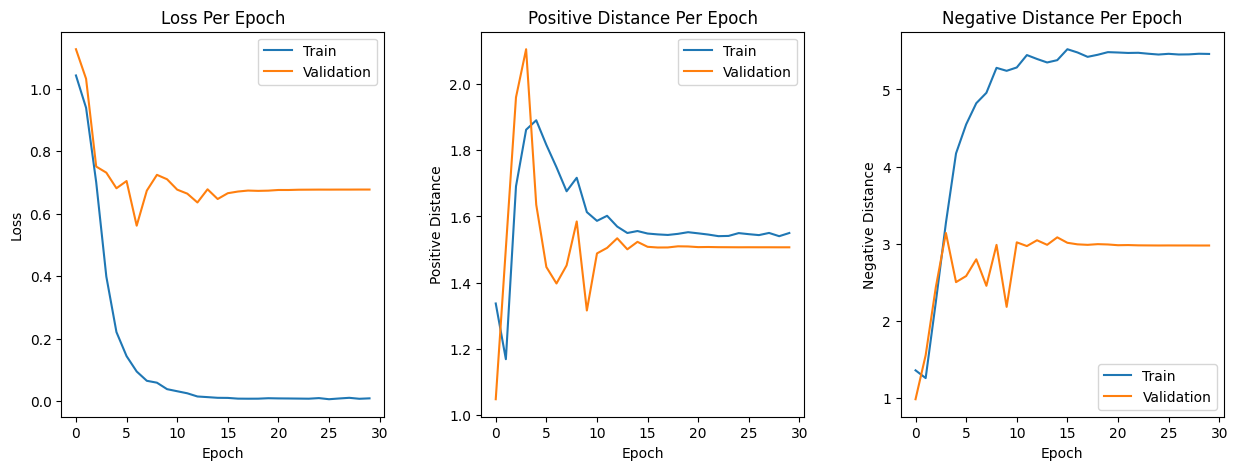

In [ ]:
# Plot evaluation results
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

# Adjust space between the subplots
fig.subplots_adjust(wspace=0.3)

# Plot loss
axs[0].plot(train_losses, label='Train')
axs[0].plot(test_losses, label='Validation')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Loss Per Epoch')
axs[0].legend()

# Plot positive distances
axs[1].plot(train_positive_dists, label='Train')
axs[1].plot(test_positive_dists, label='Validation')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Positive Distance')
axs[1].set_title('Positive Distance Per Epoch')
axs[1].legend()

# Plot negative distances
axs[2].plot(train_negative_dists, label='Train')
axs[2].plot(test_negative_dists, label='Validation')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Negative Distance')
axs[2].set_title('Negative Distance Per Epoch')
axs[2].legend()

plt.show()

## 2.6 Evaluation of Model on test set

In [ ]:
model_triplet.eval()
test_loss, test_positive_dist, test_negative_dist = test(test_loader)

Test Loss: 0.615, Test Positive Distance: 1.534, , Test Negative Distance: 3.184


# **Part 3: Re-train the model for binary classification**

## Initialize Hyperparameters

In [ ]:
batch_size = 200
num_epochs = 20
num_workers = 1

## **3.1 Data Preparation**

### **3.1.5. Create DataLoaders for training/validation/test**

In [ ]:
##Transformations for data augmentation
transform_train = transforms.Compose([transforms.RandomRotation(10),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean, std)
                                      ])

transform_test_val = transforms.Compose([transforms.ToTensor(),
                                         transforms.Normalize(mean, std)
                                        ])


# Create datasets
train_set_bi = Binary(train_images, train_labels, trans=transform_train)
val_set_bi = Binary(val_images, val_labels, trans=transform_test_val)
test_set_bi = Binary(test_images, test_labels, trans=transform_test_val)

# Create DataLoaders
train_loader_bi = DataLoader(train_set_bi, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader_bi = DataLoader(val_set_bi, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader_bi = DataLoader(test_set_bi, batch_size=batch_size, shuffle=False, num_workers=num_workers)

## **3.2 Transfer Learning**


Transfer learning was used to take the model after the first training and re-train it for binary classification.
Model's parameters were saved in a file model_triplet.pth. So I had to take that model and apply the trained weights and bias.
Tried to import the ViT class from the original DL_Project and add different layers to de neuronal network to do the binary classification but there were some problems, f. i. !git clone https://github.com/vc1492a/Hey-Waldo.git line of the original file gives problems.

Instead, I created a new file called  model_ViT.ipynb with only the
definition of the ViT, Patchify, FeedForward, MultiHeadAttention and
Transformer. Then I saved it as model_ViT.py So I could import the model's base and apply the weights and bias stored at the .pyh.

I used the following code:




Afterwards, I needed to add some layers in the end of the Neuronal Network. It seemed to work because the code did not give errors and you could see the implemented layers when printing the model. However, when making predictions, the output data had the shape of the last layer of the initial model, not the modified one.

So, I made another last change to make it work. I modified the model_ViT.ipynb adding the layers I wanted in the end, so I had what was required after importing the class.

Because of this, I had to change the code when importing the trained weights and biases. I needed to add "strict=False" to:

    model_state_dict = model.load_state_dict(checkpoint['model'], strict=False)

 Thus, although the model parameters have different size than the new model, parameters fit good and the new layers are initialised with random numbers.

This is a binary classification task, so 1 output feature is needed in the model. A sigmoid activation function is required as well in order to have a probability between 0 and 1 in the output. This probability will indicate how likely is to be Waldo. If the value is <0.5, the predicted class is NotWaldo. Otherwise, if the value>0.5, the prediction is Waldo.

On the other hand, multiple hidden layers can be used to make a deeper neuronal network, as well as intermediate activation functions and dropouts. Multiple choices have been tried and the best best performance so far is one layer from 512 input features to 1 output features and a sigmoid activation layer. More layers can produce a greater overfitting to the training images.


In this code, the required class is going to be defined as follows.

In [ ]:
# Define ViT model by combining all the modules we defined above, into our final ViT model.
class ViT_binary(nn.Module):
    def __init__(self, image_size, patch_size, num_classes, dim, num_layers, heads, dropout):
        '''
        dim: Dimension of patch embeddings.
        num_layers: Number of transformer layers.
        heads: Number of attention heads in the multi-head attention mechanism.
        '''
        super().__init__()

        self.patchify = Patchify(image_size, patch_size, dim)
        # positional encoding provides information about the position of the patches in the input sequence.
        # helps the model to consider the position of each patch when processing the image.
        # nn.Parameter means it's a learnable parameter and is updated during training.
        # (1, self.patchify.num_patches, dim) is the shape of position for each patch.
        self.pos_encoding = nn.Parameter(torch.randn(1, self.patchify.num_patches, dim))
        self.transformer = Transformer(dim, num_layers, heads, dropout = dropout)

        ## Binary classification layer 1
        self.layer_class1 = nn.Linear(dim, 1)
        self.sigmoid = nn.Sigmoid()


        ## Binary classification layer 2
        # self.layer_class2 = nn.Linear(dim//2, 1)
        #self.dropout_c = nn.Dropout(dropout)
        # self.relu = nn.ReLU()

    def forward(self, x):
        x = self.patchify(x)         # (batch_size, N, dim)
        x = x + self.pos_encoding    # (batch_size, N, dim)
        x = self.transformer(x)      # (batch_size, N, dim)
        x = x.mean(1)                # (batch_size, dim)


        x = self.layer_class1(x)       # (batch_size, N, 1)
        x = self.sigmoid(x)


        # Tried with the following code to add 2 (tried with even 3 layers) but the performance is similar. It overfits faster.
        # x = self.relu(self.layer_class1(x))       # (batch_size, N, dim/2)
        # x = self.dropout_c(x)                     # (batch_size, N, dim/2)
        # x = self.layer_class2(x)                  # (batch_size, N, 1)
        # x = self.sigmoid(x)                       # (batch_size, N, 1)

        return x                                    # (batch_size, N, 1)

Using 3 or 2 layers, the model overfits easily. A simpler model is better regarding the overfitting, but the perform is similar.

In [ ]:
image_size = 128    ## Size of the images
patch_size = 8
num_classes = 2
heads = 8
dim = 512
num_layers = 3  ## RGB images
dropout = 0.3 ## Increase dropout is typically used to control overfitting. However, the model overfits regardless of the dropout value.

model = ViT_binary(image_size = image_size,
            patch_size = patch_size,
            num_classes = num_classes,
            dim = dim,
            num_layers = num_layers,
            heads = heads,
            dropout = dropout).to(device)

# Load the model parameters
## The next commented line is used to import the model document model_triplet.pth with the weight and biases of the pretrained model
parameters_pretrained = torch.load('/content/drive/MyDrive/model_triplet.pth')
model.load_state_dict(parameters_pretrained['model'], strict=False)

_IncompatibleKeys(missing_keys=['layer_class1.weight', 'layer_class1.bias'], unexpected_keys=[])

Print the model to see the architecture

In [ ]:
model

ViT_binary(
  (patchify): Patchify(
    (proj): Conv2d(3, 512, kernel_size=(8, 8), stride=(8, 8))
  )
  (transformer): Transformer(
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (layers): ModuleList(
      (0-2): 3 x ModuleList(
        (0): MultiHeadAttention(
          (query): Linear(in_features=512, out_features=512, bias=True)
          (keys): Linear(in_features=512, out_features=512, bias=True)
          (values): Linear(in_features=512, out_features=512, bias=True)
          (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.3, inplace=False)
        )
        (1): FeedForward(
          (net): Sequential(
            (0): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (1): Linear(in_features=512, out_features=2048, bias=True)
            (2): ReLU()
            (3): Dropout(p=0.3, inplace=False)
            (4): Linea

There are two different ways to train the model:


*   Train all the different model layers with a small learning rate to do small steps of the weights and bias.
*   Freeze the layers of the pre-trained model and train only the layers on the bottom. Higher values of the lr can be used.

Both approaches were tried and the second one provides better results, in the first one the model doesn't learn This can happen because the pre-trained model do not have enough accuracy for the task and the parameters of the new layer barely change.



In [ ]:
# to activate all the parameters in the model
# for p in model.parameters():
#     p.requires_grad = True

In [ ]:
# Only activate the layers in the top
for n, p in model.named_parameters():
    if n.startswith('layer_class1'):
        p.requires_grad = True  ## When optimizer_bi.step() the weights and bieases will change
    else:
        p.requires_grad = False

## **3.3 Train the model by binary classification**



### Train function

In [ ]:
import time
import copy
threshold = 0.5         ## used for binary classification threshold. A higher probability than that will be Waldo
def train_model_bi(train_loader_bi):
    model.train()
    train_loss = 0
    correct = 0

    train_acc_sum = 0
    all_preds = []
    all_labels = []

    for b_index, (im, l) in enumerate(train_loader_bi):
      im = im.to(device)
      l = l.to(device)
      # forward pass
      outputs = model(im)                       ## Make a prediction with the batch images
      #preds = (outputs > 0.5).float()
      l = l.reshape(-1)
      preds = outputs.reshape(-1)
      #labels = labels.float()
      #labels.requires_grad_()
      preds.requires_grad_()                    ## there are error if I do not activate the gradient for predictions
      #preds = preds.float()

      loss = loss_fn(preds, l)                  ## Compute the loss
      optimizer_bi.zero_grad()                  ## When the forward pass, pytorch computes gradients in the parameters, they are set to zero for the backward pass
      loss.backward()                           ## Go backward in the neuronal network and compute the weights and biases with the computed loss
      optimizer_bi.step()                       ## Updating the model parameters with the optimizer

      ### Save the loss and the accuracy of training
      train_loss += loss.item()
      train_acc = 100*(preds.round() == l).float().mean()   ## If the value of the prediction is between 0 and 0.5, NotWaldo predicted
                                                            ## if prediction > 0.5. Waldo predicted.
      train_acc_sum += train_acc

      ## Save the predictions and labels of the training
      preds_binary = (outputs > threshold).float()
      preds_binary = preds_binary.reshape(-1)
      all_preds.extend(preds_binary.cpu().numpy())
      all_labels.extend(l.cpu().numpy())

    train_epoch_acc =  train_acc_sum / (b_index+1)
    train_epoch_loss = train_loss/(b_index+1)
    return all_preds, all_labels, train_epoch_loss, train_epoch_acc


### Test function

In [ ]:
# Define validatoin loop funtion for one iteration for validation dataloader
def test_model_bi(test_loader):
    model.eval()
    val_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for b_index, (im, l) in enumerate(test_loader):
            im = im.to(device)
            l = l.to(device)

            outputs = model(im)
            preds = outputs
            l = l.reshape(-1)
            preds = preds.reshape(-1)

            #labels = labels.float()
            #labels.requires_grad_()
            # preds.requires_grad_()
            #preds = preds.float()
            loss = loss_fn(preds, l)
            preds_binary = (outputs > threshold).float()    ## If the value of the prediction is between 0 and 0.5, NotWaldo predicted
                                                      ## if prediction > 0.5. Waldo predicted.
            preds_binary = preds_binary.reshape(-1)
            val_loss += loss.item()

            # Collect predictions and true labels for computing metrics at the end
            all_preds.extend(preds_binary.cpu().numpy())
            all_labels.extend(l.cpu().numpy())


    loss = val_loss/(b_index+1)

    return all_labels, all_preds, loss

### Precision, recall, f1 and confusion matrix functions

### Set Parameters for training: criterion, optimizer and scheduler

*   Loss_fn: The Binary Cross-Entropy (BCE) is widely used for classification models.
*   Optimizer: only changes the parameters of the fully connected layer on the top of the model. The lr is 0.0001, to learn little by little. If not, the training accuracy increases really fast. However, the validation F1 increases slowly and do not reach a good value.
*   Scheduler: used to decrement the learning rate in each poch to perform the learning. As the model approaches the best fitting weights and biases, learning must be slowed down to fit more accurately.

In [ ]:
## https://neptune.ai/blog/pytorch-loss-functions
loss_fn =  nn.BCELoss()
#criterion_bi = nn.BCEWithLogitsLoss()

optimizer_bi = torch.optim.SGD(model.layer_class1.parameters(), lr=0.0001, weight_decay=0.3)
#optimizer_bi = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.01)

## Scheduler useful to tone the lr. In the begining the lr is high and it gets reduced.
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_bi, T_max=num_epochs)
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer_bi, gamma=0.1)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer_bi, step_size=5, gamma=0.1)

### Training

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

## Create a result dictionary in case in case it is not created later. Avoid errors
results = {
          "epoch": 0,
          "precision": 0,
          "recall": 0,
          "f1": 0,
          "loss_train": 0,
          "loss_test": 0,
          "acc_train": 0,
          "acc_test": 0,
          "labels": 0,
          "preds":0,
          "model": 0
          }


best_acc = 0

## Store the losses, accuracies and (precision, recall and f1) for graphing
losses_train = []
losses_test = []
accuracies_train = []

precision = []
recall = []
f1 = []

best_f1 = 0                    ## to store the best epoch results, wich has the best f1 score


print("Starting Training...")
for epoch in range(num_epochs):
    preds_train, labels_train, train_loss, train_acc = train_model_bi(train_loader_bi)
    losses_train.append(train_loss)
    accuracies_train.append(train_acc.cpu().numpy())

    torch.cuda.empty_cache()

    scheduler.step()  ## Reduce the learning rate
    labels_val, preds_val, loss = test_model_bi(val_loader_bi) ## Test the performance of the model in the validation dataset

    # Compute precision, recall, and F1 score
    labels_tensor = torch.tensor(labels_val)
    preds_tensor = torch.tensor(preds_val)
    p = precision_score(labels_tensor, preds_tensor)
    r = recall_score(labels_tensor, preds_tensor)
    f = f1_score(labels_tensor, preds_tensor)


    ## Print all the indicators
    print('Epoch {} / {}'.format(epoch, num_epochs))
    print('Train Loss: {:.3f}'.format(train_loss))
    print('Val Loss: {:.3f}'.format(loss))
    print('Train Accuracy: {:.3f}'.format(train_acc))
    print('Precision: {:.3f}, Recall: {:.3f}, F1-score: {:.3f}'.format(p, r, f))

    ## Make a list to graph
    precision.append(p)
    recall.append(r)
    f1.append(f)

    ## Store the best f1-score performance of the epoches. This is going to be stored and used in the test set.
    if f>best_f1:
      best_f1 = f
      results = {
          "epoch": epoch+1,
          "precision": p,
          "recall": r,
          "f1": f,
          "loss_train": train_loss,
          "loss_test": loss,
          "acc_train": train_acc,
          "labels_train": labels_train,
          "preds_train":preds_train,
          "labels_val": labels_val,
          "preds_val":preds_val,
          "model": model.state_dict()
          }

    losses_test.append(loss)
    torch.cuda.empty_cache()

model_to_save = {
    "precision": results["precision"],
    "recall": results["recall"],
    "f1": results["f1"],
    "loss_train": results["loss_train"],
    "loss_test": results["loss_test"],
    "acc_train": results["acc_train"],
    "model": results["model"]
    }

# Define path to save model's state file
path = os.path.join(model_state_path, 'model_classification.pth')
torch.save(model_to_save, path)

Starting Training...
Epoch 0 / 20
Train Loss: 0.746
Val Loss: 0.889
Train Accuracy: 48.788
Precision: 0.010, Recall: 1.000, F1-score: 0.020
Epoch 1 / 20
Train Loss: 0.726
Val Loss: 0.801
Train Accuracy: 48.789
Precision: 0.010, Recall: 1.000, F1-score: 0.020
Epoch 2 / 20
Train Loss: 0.715
Val Loss: 0.749
Train Accuracy: 44.969
Precision: 0.010, Recall: 1.000, F1-score: 0.020
Epoch 3 / 20
Train Loss: 0.708
Val Loss: 0.717
Train Accuracy: 31.373
Precision: 0.004, Recall: 0.333, F1-score: 0.007
Epoch 4 / 20
Train Loss: 0.703
Val Loss: 0.694
Train Accuracy: 28.783
Precision: 0.003, Recall: 0.167, F1-score: 0.005
Epoch 5 / 20
Train Loss: 0.698
Val Loss: 0.679
Train Accuracy: 39.027
Precision: 0.009, Recall: 0.167, F1-score: 0.017
Epoch 6 / 20
Train Loss: 0.693
Val Loss: 0.669
Train Accuracy: 48.794
Precision: 0.033, Recall: 0.167, F1-score: 0.056
Epoch 7 / 20
Train Loss: 0.689
Val Loss: 0.659
Train Accuracy: 54.756
Precision: 0.125, Recall: 0.167, F1-score: 0.143
Epoch 8 / 20
Train Loss: 0.

## **3.4 Results**

### Print the results for the best F1-score of the epochs

#### Validation dataset best performance




Best results in validation set:
epoch: 15.000
precision: 1.000
recall: 0.833
f1: 0.909
loss_train: 0.673
loss_test: 0.636
acc_train: 72.256


<Axes: >

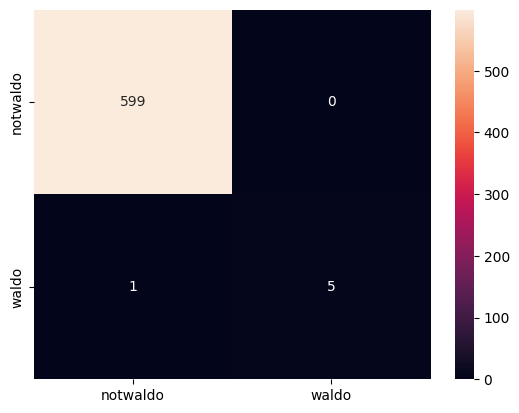

In [ ]:
print("Best results in validation set:")
for key, value in results.items():
  if key!="model" and  key!="labels_train" and key!="preds_train" and key!="labels_val" and key!="preds_val":
    print("{}: {:.3f}".format(key, value))

matrix = confusion_matrix(results["labels_val"], results["preds_val"])
sns.heatmap(matrix, xticklabels=['notwaldo', 'waldo'], yticklabels=['notwaldo', 'waldo'], annot=True, fmt="d")

#### Training dataset

In training dataset:
Precision: 0.995, Recall: 0.433, F1: 0.604
Accuracy in training: 72.3%


<Axes: >

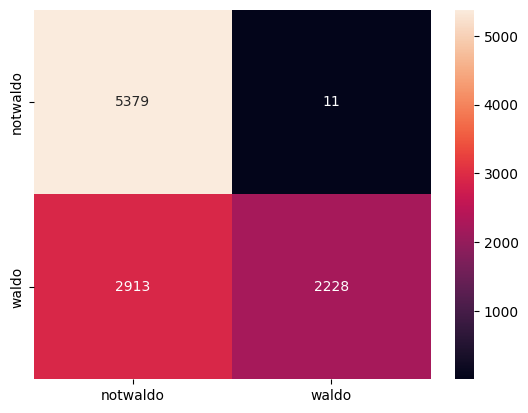

In [ ]:
p_train = precision_score(results["labels_train"], results["preds_train"])
r_train = recall_score(results["labels_train"], results["preds_train"])
f_train = f1_score(results["labels_train"], results["preds_train"])
print("In training dataset:")
print("Precision: {:.3}, Recall: {:.3}, F1: {:.3}".format(p_train, r_train, f_train))
print("Accuracy in training: {:.3}%".format(results["acc_train"]))
matrix = confusion_matrix(results["labels_train"], results["preds_train"])
sns.heatmap(matrix, xticklabels=['notwaldo', 'waldo'], yticklabels=['notwaldo', 'waldo'], annot=True, fmt="d")

The model overfits from the beginning, so the indicators are high. The performance in the training set is awesome but the model does not know to predict new data in the validation and test datasets.

### Precision, recall and f1 evolution in validation dataset

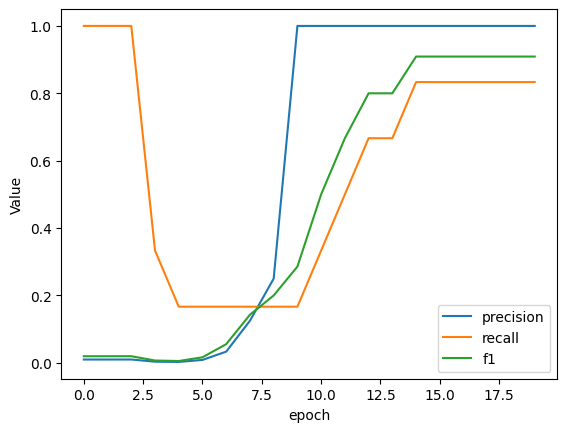

In [ ]:
plt.plot(precision, label="precision")
plt.plot(recall, label="recall")
plt.plot(f1, label="f1")

plt.xlabel('epoch')
plt.ylabel('Value')
plt.legend()

Precision, recall, and the most important indicator, f1, go to low values of 0.333, and stagnate.

### Losses evolution

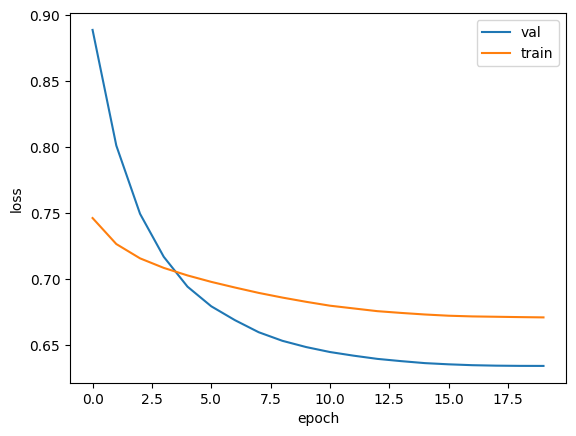

In [ ]:
plt.plot(losses_test, label='val')
plt.plot(losses_train, label='train')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

The final train loss is 0.451 and the final val loss is 0.363

### Accuracies evolution

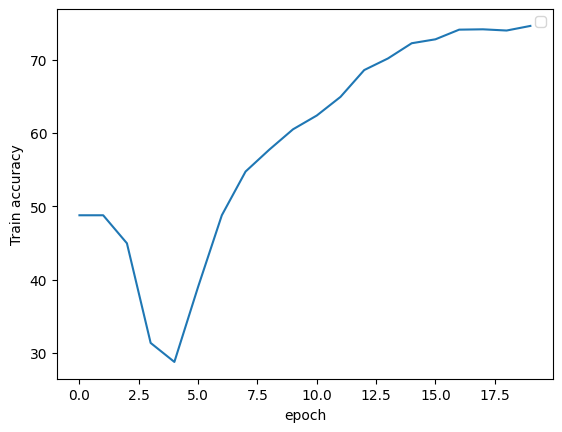

In [ ]:
plt.plot(accuracies_train)
plt.xlabel('epoch')
plt.ylabel('Train accuracy')
plt.legend()

The train accuracy goes slowly to 97% because the learning rate is 0.0001. If f.i., lr was 0.1, it would be 90% in the second epoch.

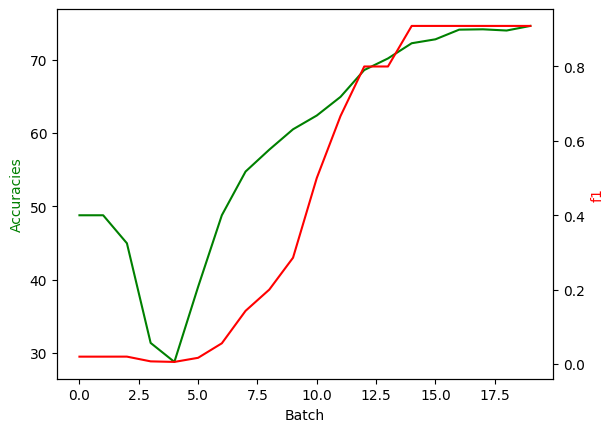

In [ ]:
# Crear el primer conjunto de ejes
_, accuracy_plot = plt.subplots()

# Plot train accuracy
accuracy_plot.plot(accuracies_train, 'g-')
accuracy_plot.set_xlabel('Batch')
accuracy_plot.set_ylabel('Accuracies', color='g')

f1_plot = accuracy_plot.twinx()

# Plot F1
f1_plot.plot(f1, 'r-')
f1_plot.set_ylabel('f1', color='r')
plt.show()

The F1 increases as the training accuracy increases, but the f1 only reach goes to 0.364 and the objective is to be as closes as possible to 1.

In testing dataset:
Precision: 1.0
Recall: 0.7142857142857143
F1-score: 0.8333333333333333


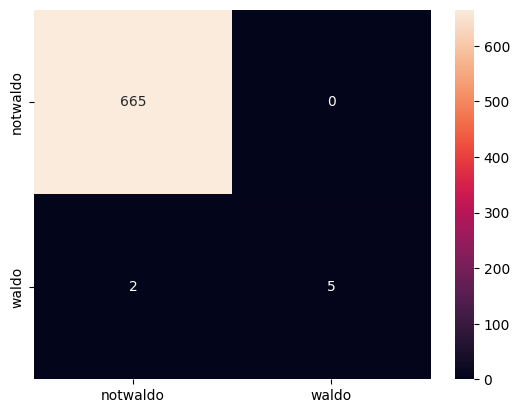

In [ ]:
model.load_state_dict(results['model'])

labels, preds, loss = test_model_bi(test_loader_bi)

# Compute precision, recall, and F1 score
labels_tensor = torch.tensor(labels)
preds_tensor = torch.tensor(preds)
p2 = precision_score(labels_tensor, preds_tensor)
r2 = recall_score(labels_tensor, preds_tensor)
f2 = f1_score(labels_tensor, preds_tensor)
print("In testing dataset:")
print("Precision: {}".format(p2))
print("Recall: {}".format(r2))
print("F1-score: {}".format(f2))
conf_matrix = confusion_matrix(labels, preds)
sns.heatmap(conf_matrix, xticklabels=['notwaldo', 'waldo'], yticklabels=['notwaldo', 'waldo'], annot=True, fmt="d");

In the images that the model did not see before (using the test dataset), the results are  good. 2 No Waldo images are predicted as Waldo.